In [185]:
# Initial imports
import os
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import json
import hvplot.pandas
import plotly.express as px
%matplotlib inline

In [186]:
# Load .env enviroment variables
load_dotenv()

True

In [187]:
#Pull in and read CSV files
csvpath = Path("..\seattle_data\Seattle_Apparel_CPI.csv")
seattleCPI_apparel_df = pd.read_csv(csvpath)

csvpath1 = Path("..\seattle_data\Seattle_FoodAwayFromHome_CPI.csv")
seattleCPI_FoodAway_df = pd.read_csv(csvpath1)

csvpath3 = Path("..\seattle_data\Seattle_RentalEquivalent_CPI.csv")
seattleCPI_RentalEquivalent_df = pd.read_csv(csvpath3)

# seattleCPI_RentalEquivalent_df
# seattleCPI_apparel_df
# seattleCPI_FoodAway_df

In [188]:
# Reset the index and reset the top row as column names 

seattleCPI_apparel_df.reset_index(drop=True, inplace=True)
seattleCPI_apparel_df.set_index("Year", inplace=True)

seattleCPI_FoodAway_df.reset_index(drop=True, inplace=True)
seattleCPI_FoodAway_df.set_index("Year", inplace=True)

seattleCPI_RentalEquivalent_df.reset_index(drop=True, inplace=True)
seattleCPI_RentalEquivalent_df.set_index("Year", inplace=True)



seattleCPI_FoodAway_df

,Annual
Year,
2012,259.603
2013,266.493
2014,271.982
2015,278.738
2016,287.958
2017,296.622
2018,305.532
2019,314.927
2020,329.670


In [189]:
# Rename the columns
seattleCPI_apparel_df.rename(columns= {'Annual': 'Seattle Apparel CPI'}, inplace= True)

seattleCPI_FoodAway_df.rename(columns= {'Annual': 'Seattle Food Away from Home CPI'}, inplace= True)

seattleCPI_RentalEquivalent_df.rename(columns= {'Annual': 'Seattle Housing CPI'}, inplace= True)


In [190]:
seattleCPI_RentalEquivalent_df

,Seattle Housing CPI
Year,
2012,283.351
2013,291.631
2014,305.272
2015,320.433
2016,339.302
2017,360.153
2018,382.350
2019,400.300
2020,414.762


In [191]:
#The dataframe types were set to object, so reset the column datatypes to numeric to enable plots and calculations
seattleCPI_apparel_df["Seattle Apparel CPI"]= pd.to_numeric(seattleCPI_apparel_df["Seattle Apparel CPI"])

seattleCPI_FoodAway_df["Seattle Food Away from Home CPI"]= pd.to_numeric(seattleCPI_FoodAway_df["Seattle Food Away from Home CPI"])

seattleCPI_RentalEquivalent_df["Seattle Housing CPI"]= pd.to_numeric(seattleCPI_RentalEquivalent_df["Seattle Housing CPI"])


In [192]:
# Calculate percent change for each df
seattleCPI_apparel_pctchange = seattleCPI_apparel_df.pct_change()

seattleCPI_FoodAway_pctchange = seattleCPI_FoodAway_df.pct_change()

seattleCPI_RentalEquivalent_pctchange = seattleCPI_RentalEquivalent_df.pct_change()


In [193]:
# Combine all dataframes together
list_of_df = [seattleCPI_apparel_df, seattleCPI_FoodAway_df, seattleCPI_RentalEquivalent_df]
seattle_CPI_data= pd.concat(list_of_df, join='inner', axis='columns')
seattle_CPI_data

,Seattle Apparel CPI,Seattle Food Away from Home CPI,Seattle Housing CPI
Year,,,
2012,136.170,259.603,283.351
2013,133.148,266.493,291.631
2014,130.279,271.982,305.272
2015,129.292,278.738,320.433
2016,130.264,287.958,339.302
2017,130.814,296.622,360.153
2018,127.582,305.532,382.350
2019,128.442,314.927,400.300
2020,124.045,329.670,414.762


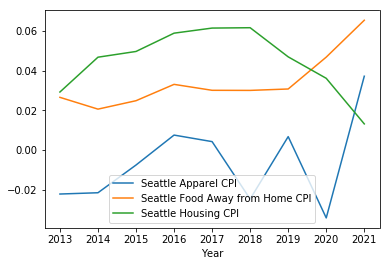

In [194]:
# Calculate the percent change for the data
seattle_pct_chg = seattle_CPI_data.pct_change()

# Sample plot
seattle_pct_chg.plot()

In [195]:
# Retreive API keys
public_key = os.getenv("ALPACA_API_KEY")
private_key = os.getenv("ALPACA_SECRET_KEY")
type(private_key)

str

In [196]:
# Create alpacas connection object
alpacas = tradeapi.REST(public_key, private_key, api_version="v2")

In [197]:
# Set timeframe for data
start = pd.Timestamp("2012-01-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()
timeframe="1Day"

In [198]:
# Create lists for tickers
real_estate = ["TSCO","DHI","LOW","LGIH"]
apparel = ["NKE", "UA","GPS", "LULU", "JWN"]
pleasure_food = ["MCD","YUM", "DRI", "QSR"]

#Create a function to get stock data
def alpacas_api(symbols,timeframe, start,end):
    dataframe = alpacas.get_bars(symbols, timeframe=timeframe, start=start, end=end).df
    new_df = dataframe[['open','close','trade_count', 'symbol']]

    return new_df

# Run function to grab stocks from each industry we are researching
Real_Estate_stocks = alpacas_api(real_estate, timeframe,start,end)
Apparel_stocks = alpacas_api(apparel, timeframe,start,end)
Food_stocks = alpacas_api(pleasure_food, timeframe,start,end)

In [199]:
# Create pivot tables for closing prices
Real_Estate_close = Real_Estate_stocks.pivot_table(values="close", index="timestamp",columns="symbol")
Apparel_close = Apparel_stocks.pivot_table(values="close", index="timestamp",columns="symbol")
Food_close = Food_stocks.pivot_table(values="close", index="timestamp",columns="symbol")

In [200]:

# Create function to reformat data to annual timeframe + percent change + reset index to year
def reformat_data(dataframe):
    dataframe = dataframe.resample("Y").mean()

    dataframe = dataframe["close"].pct_change()
    dataframe.index =dataframe.index.year
    return dataframe

# Run the function through stock dataframes and create new variables
Real_estate_stock_annual = reformat_data(Real_Estate_stocks)
Apparel_stock_annual = reformat_data(Apparel_stocks)
Food_stock_annual = reformat_data(Food_stocks)

Real_estate_stock_annual = pd.DataFrame(Real_estate_stock_annual).dropna()
Apparel_stock_annual = pd.DataFrame(Apparel_stock_annual).dropna()
Food_stock_annual = pd.DataFrame(Food_stock_annual).dropna()

# Real_estate_stock_annual.index.names = ["Year"]
# seattleCPI_RentalEquivalent_df.reset_index(drop=True, inplace=True)


Real_estate_stock_annual




,close
timestamp,
2016,-0.022360
2017,0.029060
2018,0.231439
2019,0.170760
2020,0.275063
2021,0.536315


In [201]:
# Create function to combine stock data with CPI data
def concat_stocks_cpi(stock, cpi):
    df = pd.concat([stock,cpi], axis=1, join= "inner")
    return df 

# Run function for CPI and stock dataframes to combine corresponding data into dataframes
Housing_combined = concat_stocks_cpi(Real_estate_stock_annual, seattleCPI_RentalEquivalent_pctchange)
Housing_combined.columns = ['Real Estate stocks', 'Seattle Housing CPI']
Housing_plot = Housing_combined.hvplot.line(xlabel='Year', ylabel="Annual Percent Change")

apparel_combined = concat_stocks_cpi(Apparel_stock_annual, seattleCPI_apparel_pctchange)
apparel_combined.columns = ['Apparel stocks', "Seattle Apparel CPI"]
apparel_plot = apparel_combined.hvplot.line(xlabel='Year', ylabel="Annual Percent Change")

food_combined = concat_stocks_cpi(Food_stock_annual, seattleCPI_FoodAway_pctchange)
food_combined.columns = ['Commerical Food stocks', "Seattle Commerical Food CPI"]
food_plot = food_combined.hvplot.line(xlabel='Year', ylabel="Annual Percent Change")

food_plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [206]:
all_data_combined = pd.concat([food_combined, Housing_combined, apparel_combined], axis=1, join= "inner")

all_data_combined.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [203]:
seattle_apparel_industry_bar = apparel_combined.hvplot.bar(rot=90, xlabel= "Years", ylabel= "Percent Change", title= " Apparel Industry Comparison")
seattle_housing_industry_bar = Housing_combined.hvplot.bar(rot=90, xlabel= "Years", ylabel= "Percent Change", title= " Housing Industry Comparison")
seattle_food_industry_bar = food_combined.hvplot.bar(rot=90, xlabel= "Years", ylabel= "Percent Change", title= " Food Industry Comparison")

In [204]:
# combined_industry_bar = seattle_apparel_industry_bar + seattle_housing_industry_bar + seattle_food_industry_bar
# combined_industry_bar

seattle_food_industry_bar

:Bars   [index,Variable]   (value)